### Case Study

The VIX is a measure of the implied volatility for the S&P500. The higher the "Close" of the VIX, the higher the uncertainty in the market. Fortunately, there are ways of capitlizing on the predictability of the VIX. Being able to predict implied volatility for the market with any degree of certainty better than 50/50 can give an options trader of ETF trader (VIX tracking ETF's) an edge.

There could be many, many features that impact whether a stock price goes up or down. Predicting directionality for stocks, the VIX, commodities, FX etc represents a huge potential gain for every small percentage increment in forecast ability.

However, having so many features allows room for noise and can create adverse impacts to your supervised learning. Therefore, we will explore deplying PCA (Principle Component Analysis) as a tool to find useful information within a vast array of indicators and features to help with our supervised learning later on.

PCA can equally be extremely good at helping to understand correlations too and further study on PCS (based on articles and papers below) is encorouged.

### Imports

In [5]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np

from ta import add_all_ta_features

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import pickle

# Reporting
import matplotlib.pyplot as plt
import yfinance

In [39]:
findFeature = False
#[OLECTRA,"LT","CONCOR","ELGIEQUIP","IOC","BEL","TATAELXSI","^NSEI"]
stock_name = "CONCOR.NS"
disableStationaryCheck = False
features = []
if findFeature == False:
    with open('./TrainedModel/indicator/{}_features.txt'.format(stock_name), 'rb') as f:
            features = pickle.load(f)
            print(feature_item)
            features.append("TARGET")



['Low', 'Close', 'volume_adi', 'volume_obv', 'volume_em', 'volume_vpt', 'volume_nvi', 'volatility_kcp', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_kama', 'others_dr', 'others_dlr', 'others_cr']


### Initial Data Extraction

In [42]:


# Data Extraction
start_date = "2017-01-01"
end_date = "2022-06-01"
#symbol = "IOC.NS"

#df = yfinance.download(tickers = stock_name,start="2010-03-06",
 #                              interval = "1d", group_by = 'ticker', auto_adjust = True)

df = pd.read_csv("./stock_historical_data/{}.csv".format(stock_name))
df.set_index("Date", inplace=True)

df = df[["Open", "High", "Low", "Close","Volume"]]
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-03,667.000000,677.349976,655.349976,657.049988,1034099
2023-07-04,666.000000,666.500000,655.799988,664.700012,1051281
2023-07-05,665.000000,674.900024,658.400024,673.049988,1193025
2023-07-06,674.000000,691.549988,671.000000,690.000000,1338976
2023-07-07,692.450012,692.599976,666.000000,670.650024,781925


In [43]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)


### Data Preprocessing - Stationarity

In [44]:
# Identify non-stationary columns

non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 31


In [45]:
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [46]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [47]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,-0.023352,-0.013883,-0.005707,-0.012297,18075,2.376360,-1.301858,-0.669955,-16270.975113,-6744.090828,...,-0.098181,-0.019636,-0.078545,2.355321,0.471064,1.884257,-0.005127,-1.229654,-1.237276,0.000000
2005-01-05,-0.011002,-0.002211,-0.012032,-0.000055,168093,1.234050,40.108089,-0.239105,-14041.817649,-730.918430,...,-0.174566,-0.050622,-0.123944,49.072175,10.191286,38.880889,-0.003017,-0.005487,-0.005487,0.004407
2005-01-06,-0.019716,-0.026922,-0.022347,-0.013277,224990,-3.029111,1.305925,0.228352,-42890.604823,-1583.133616,...,-0.337741,-0.108046,-0.229695,65.735283,21.300086,44.435197,-0.007263,-1.327706,-1.336598,1.061725
2005-01-07,-0.033708,-0.000111,-0.017143,-0.018480,19715,-0.009672,0.049626,0.216119,-40476.655450,-9697.282309,...,-0.607473,-0.207931,-0.399542,53.571278,27.754324,25.816954,-0.012366,-1.848028,-1.865317,0.707267
2005-01-10,0.045349,-0.001000,0.000058,0.006200,75646,0.199020,-0.181410,0.221464,-30002.265805,-138.810261,...,-0.765243,-0.319394,-0.445849,49.421016,32.087663,17.333354,-0.004388,0.620043,0.618128,-0.136425


### Data Preprocessing - Scaling and Target Setting

In [48]:
# Set Target (for Supervised ML later on)
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Close"].shift(-1) > df_stationary["Close"], "TARGET"] = 1
df_stationary.dropna(inplace=True)

In [49]:
features

['Low',
 'Close',
 'volume_adi',
 'volume_obv',
 'volume_em',
 'volume_vpt',
 'volume_nvi',
 'volatility_kcp',
 'trend_ema_fast',
 'momentum_stoch_rsi_k',
 'momentum_kama',
 'others_dr',
 'others_dlr',
 'others_cr',
 'TARGET']

In [50]:
# Convert non-stationaries to stationary
if findFeature == False:
    df_stationary = df_stationary[features]
print(df_stationary)

                 Low     Close  volume_adi  volume_obv     volume_em  \
Date                                                                   
2005-01-04 -0.005707 -0.012297    2.376360   -1.301858  -6744.090828   
2005-01-05 -0.012032 -0.000055    1.234050   40.108089   -730.918430   
2005-01-06 -0.022347 -0.013277   -3.029111    1.305925  -1583.133616   
2005-01-07 -0.017143 -0.018480   -0.009672    0.049626  -9697.282309   
2005-01-10  0.000058  0.006200    0.199020   -0.181410   -138.810261   
...              ...       ...         ...         ...           ...   
2023-07-03  0.004753 -0.007177    0.005351   -0.002743  17923.789835   
2023-07-04  0.000687  0.011643   -0.004247    0.002797  -5292.578060   
2023-07-05  0.003965  0.012562   -0.005659    0.003165   7606.756232   
2023-07-06  0.019137  0.025184   -0.006991    0.003541  22445.730494   
2023-07-07 -0.007452 -0.028043    0.003149   -0.002061  -6718.689661   

              volume_vpt  volume_nvi  volatility_kcp  trend_ema

In [51]:
# Split Target from Featureset
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [52]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [53]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

### Unsupervised ML - PCA Dimensionality Reduction

### Supervised ML - Random Forest Classification

In [54]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.7302281963113473
Test Precision: 0.7019064124783362


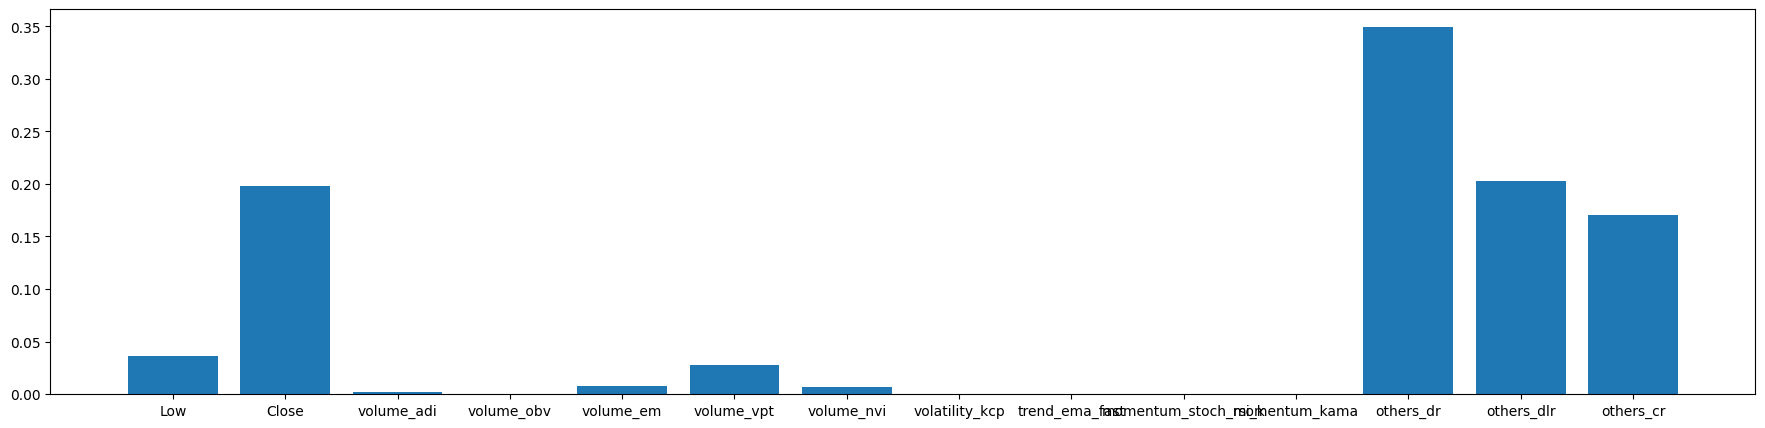

In [55]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [56]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

/var/folders/4_/_fbkdkz531s_92lxx_c_x6n00000gn/T/ipykernel_858/3002898103.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


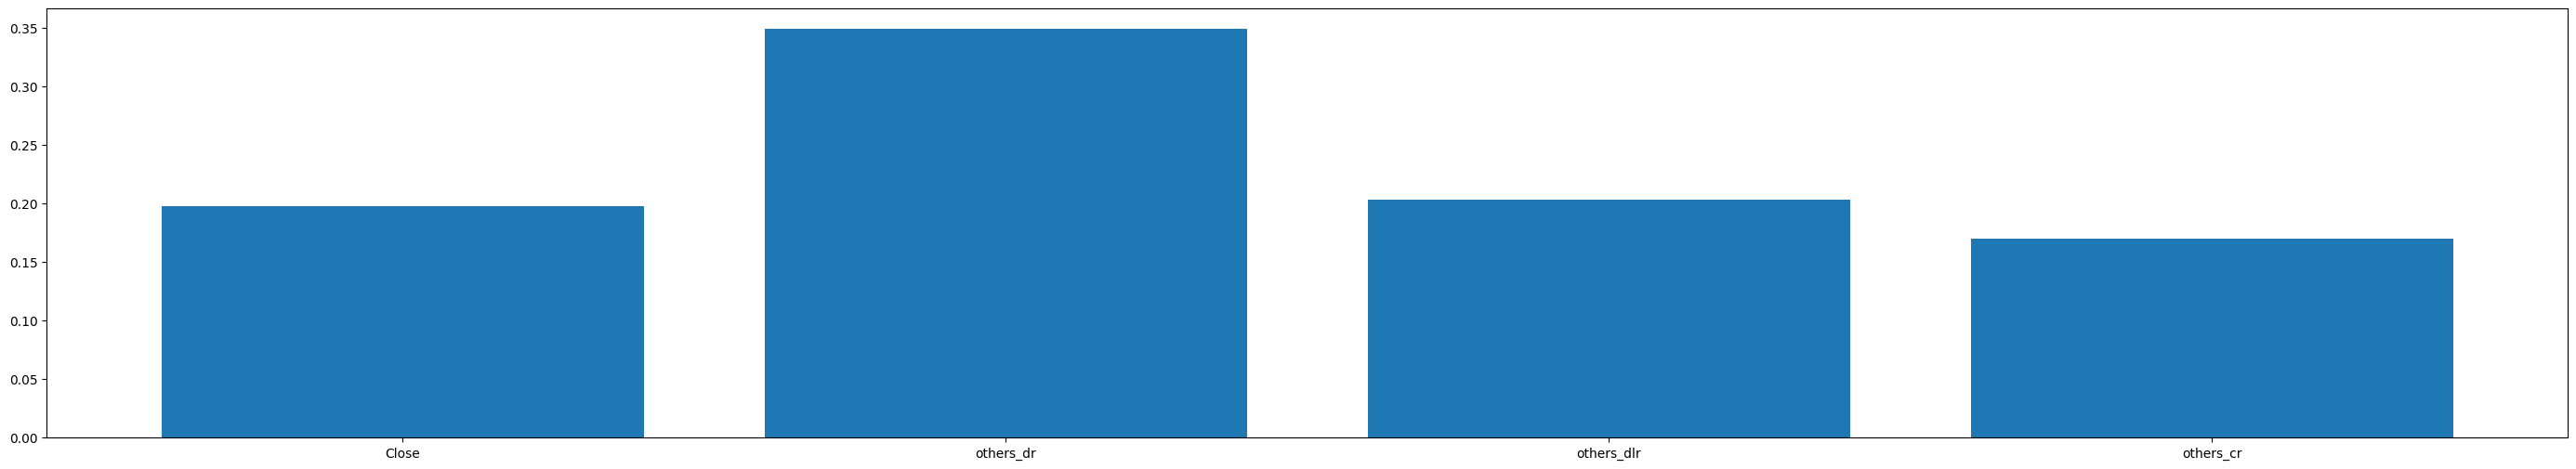

In [57]:
fig, ax = plt.subplots(figsize=(35, 6))

ax.bar(recommended_feature_labels, recommended_feature_score)
fig.show()

In [58]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.8517541 , 0.1482459 ],
       [0.4265174 , 0.5734826 ],
       [0.85693522, 0.14306478],
       ...,
       [0.1771659 , 0.8228341 ],
       [0.74027412, 0.25972588],
       [0.31075724, 0.68924276]])

In [61]:
# Test for Overfitting
train_scores, test_scores = list(), list()

values = [i for i in range(1, 200)]
for i in values:
    classifier = {}
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
   
    #with open('./TrainedModel/indicator/{}_model_2.pkl'.format(stock_name), 'rb') as f:
     #   classifier = pickle.load(f)
        
    classifier.fit(X_train, y_train)
    
    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)
    
    # Test Data
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)

In [62]:
test_scores

[0.7258518286964677,
 0.7261644263832447,
 0.7277274148171303,
 0.7289778055642389,
 0.7296030009377931,
 0.7292904032510159,
 0.7289778055642389,
 0.7305407939981244,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7305407939981244,
 0.7308533916849015,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7305407939981244,
 0.7302281963113473,
 0.7302281963113473,
 0.7305407939981244,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7305407939981244,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963113473,
 0.7302281963

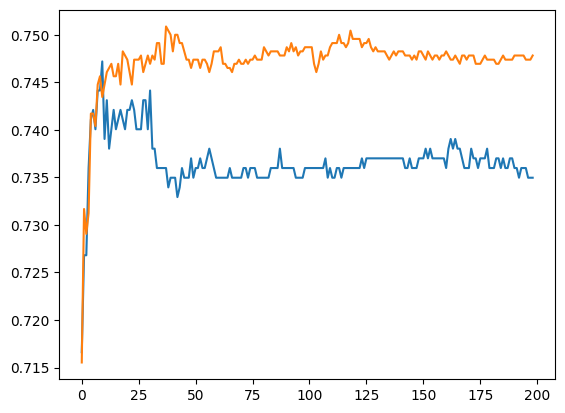

In [21]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()

In [22]:
# Save the trained model to a file
import pickle

if findFeature == False:
    with open('./TrainedModel/indicator/{}_model_2.pkl'.format(stock_name), 'wb') as f:
        pickle.dump(classifier, f)

In [23]:
# Save the trained model to a file
if findFeature == True:
    print(recommended_feature_labels)
    with open('./TrainedModel/indicator/{}_features.txt'.format(stock_name), 'wb') as f:
        pickle.dump(recommended_feature_labels, f)

### Conclusion

We have seen that by introducing PCA, we can dramatically reduce the amount of data required to train our supervised machine learning model (in this case Random Forest). One could further explore information provided by PCA by running K-Means clusters on the PCA data to find certain regimes in the data.

This is the fun part about machine learning, there are many ways to combine methods in the aim to optimize your strategy.

### Useful Resources and Reading

Use Case in Correlation for Stock Analysis: https://python.plainenglish.io/applying-pca-to-stocks-fbad2e51573f

Understanding the VIX: https://www.investopedia.com/stock-analysis/2012/4-ways-to-trade-the-vix-vxx-vxz-tvix-xxv0504.aspx

Using PCA in Forex Trading: 
https://deanstreetlab.github.io/papers/papers/FX%20Trading/Using%20a%20Principal%20Component%20Analysis%20for%20Multi-Currencies-Trading%20in%20the%20Foreign%20Exchange%20Market.pdf